출처 : https://wikidocs.net/45609

## **07-12 피드 포워드 신경망 언어 모델(Neural Network Language Model, NNLM)**
---


파이썬 등과 같은 프로그래밍 언어를 사용할 때는 명세되어져 있는 튜플, 클래스 등과 같은 용어와 작성할 때 지켜야 하는 문법을 바탕으로 코드를 작성합니다. 문법에 맞지 않으면 에러가 발생하므로 명세된 규칙을 지키는 것은 필수적입니다.

자연어는 어떨까요? 자연어에도 문법이라는 규칙이 있기는 하지만, 많은 예외 사항, 시간에 따른 언어의 변화, 중의성과 모호성 문제 등을 전부 명세하기란 어렵습니다. 기계가 자연어를 표현하도록 규칙으로 명세하기가 어려운 상황에서 대안은 규칙 기반 접근이 아닌 기계가 주어진 자연어 데이터를 학습하게 하는 것입니다.

과거에는 기계가 자연어를 학습하게 하는 방법으로 통계적인 접근을 사용했으나, 최근에는 인공 신경망을 사용하는 방법이 자연어 처리에서 더 좋은 성능을 얻고 있습니다. 번역기, 음성 인식 등과 같이 **자연어 생성(Natural Language Generation, NLG)** 의 기반으로 사용되는 언어 모델도 마찬가지입니다. **통계적 언어 모델(Statistical Language Model, SLM)** 에서 다양한 구조의 인공 신경망을 사용한 언어 모델들로 대체되기 시작했습니다.

여기서는 신경망 언어 모델의 시초인 **피드 포워드 신경망 언어 모델(Feed Forward Neural Network Language Model)** 에 대해서 학습합니다. 여기서는 간단히 줄여 NNLM이라고 합시다. 뒤에서 RNNLM, BiLM 등 보다 발전된 신경망 언어 모델들을 배웁니다.
  

> 이 모델은 제안 되었을 당시 **NPLM(Neural Probabilistic Language Model)** 이라는 이름을 갖고 있었습니다.


---
### **1. 기존 N-gram 언어 모델의 한계**

언어 모델은 문장에 확률을 할당하는 모델이며, 주어진 문맥으로부터 아직 모르는 단어를 예측하는 것을 언어 모델링이라고 한다고 언급한 바 있습니다. 다음은 이전 단어들로부터 다음 단어를 예측하는 **언어 모델링(Language Modeling)** 의 예를 보여줍니다.

```python
    # 다음 단어 예측하기
    An adorable little boy is spreading ____

```
위 문장을 가지고 앞서 배운 n-gram 언어 모델이 언어 모델링을 하는 방법을 복습해봅시다.

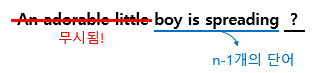

n-gram 언어 모델은 언어 모델링에 바로 앞 n-1개의 단어를 참고합니다. 4-gram 언어 모델이라고 가정해봅시다. 모델은 바로 앞 3개의 단어만 참고하며 더 앞의 단어들은 무시합니다. 위 예제에서 다음 단어 예측에 사용되는 단어는 boy, is, spreading입니다.

$$P(w\text{|boy is spreading}) = \frac{\text{count(boy is spreading}\ w)}{\text{count(boy is spreading)}}$$  
  


  
그 후에는 훈련 코퍼스에서 (n-1)-gram을 카운트한 것을 분모로, n-gram을 카운트한 것을 분자로 하여 다음 단어가 등장 확률을 예측했습니다. 예를 들어 갖고있는 코퍼스에서 boy is spreading가 1,000번, boy is spreading insults가 500번, boy is spreading smiles가 200번 등장했다면 각 확률은 아래와 같습니다.  
  
$$P(\text{insults|boy is spreading}) = 0.500$$
$$P(\text{smiles|boy is spreading}) = 0.200$$   
  


하지만 이러한 n-gram 언어 모델은 충분한 데이터를 관측하지 못하면 언어를 정확히 모델링하지 못하는 **희소 문제(sparsity problem)** 가 있었습니다. 예를 들어 훈련 코퍼스에 '$\text{boy is spreading smile}$'라는 단어 시퀀스가 존재하지 않으면 n-gram 언어 모델에서 해당 단어 시퀀스의 확률 $P(\text{smiles|boy is spreading})$ 는 0이 됩니다. 이는 언어 모델이 판단하기에 boy is spreading 다음에는 smiles이란 단어가 나올 수 없다는 의미이지만 해당 단어 시퀀스는 현실에서 존재 가능한 시퀀스이므로 적절한 모델링이 아닙니다.

---
### **2. 단어의 의미적 유사성**

희소 문제는 기계가 단어의 의미적 유사성을 알수 있다면 해결할 수 있는 문제입니다. 실제 사람의 사례를 들어 이야기해보겠습니다. 저자는 최근 '톺아보다'라는 생소한 단어를 배웠고, '톺아보다'가 '샅샅이 살펴보다'와 유사한 의미임을 학습했습니다. 그리고 '발표 자료를 살펴보다'라는 표현 대신 '발표 자료를 톺아보다'라는 표현을 써봤습니다. 저는 '발표 자료를 톺아보다'라는 예문을 어디서 읽은 적은 없지만 두 단어가 유사함을 학습하였으므로 단어를 대신 선택하여 자연어 생성을 할 수 있었습니다.

기계도 마찬가지입니다. '발표 자료를 살펴보다'라는 단어 시퀀스는 존재하지만, '발표 자료를 톺아보다'라는 단어 시퀀스는 존재하지 않는 코퍼스를 학습한 언어 모델이 있다고 가정해봅시다. 언어 모델은 아래 선택지에서 다음 단어를 예측해야 합니다.

$$P(\text{톺아보다|발표 자료를})$$
$$P(\text{냠냠하다|발표 자료를})$$  
  
저자의 경우에는 '살펴보다'와 '톺아보다'의 유사성을 학습하였고 이를 근거로 두 선택지 중에서 '톺아보다'가 더 맞는 선택이라고 판단할 수 있습니다. 하지만 n-gram 언어 모델은 '발표 자료를' 다음에 '톺아보다'가 나올 확률 $P(\text{톺아보다|발표 자료를})$를 0으로 연산합니다. n-gram 언어 모델은 '살펴보다'와 '톺아보다'의 단어의 유사도를 알 수 없으므로 예측에 고려할 수 없습니다.

만약 언어 모델 또한 단어의 의미적 유사성을 학습할 수 있도록 설계한다면, 훈련 코퍼스에 없는 단어 시퀀스에 대한 예측이라도 유사한 단어가 사용된 단어 시퀀스를 참고하여 보다 정확한 예측을 할 수 있습니다. 그리고 이러한 아이디어를 반영한 언어 모델이 신경망 언어 모델 **NNLM** 입니다. 그리고 이 아이디어는 단어 벡터 간 유사도를 구할 수 있는 벡터를 얻어내는 **워드 임베딩(word embedding)** 의 아이디어이기도 합니다. NNLM이 어떻게 훈련 과정에서 단어의 유사도를 학습할 수 있는지 알아봅시다.

---
### **3. 피드 포워드 신경망 언어 모델(NNLM)**

NNLM이 언어 모델링을 학습하는 과정을 보겠습니다. 이해를 위해 간소화 된 형태로 설명합니다.

* **예문 : "what will the fat cat sit on"**  

예를 들어 훈련 코퍼스에 위와 같은 문장이 있다고 해봅시다. 언어 모델은 주어진 단어 시퀀스로부터 다음 단어를 예측합니다. 훈련 과정에서는 'what will the fat cat'이라는 단어 시퀀스가 입력으로 주어지면, 다음 단어 'sit'을 예측하는 방식으로 훈련됩니다.

훈련 코퍼스가 준비된 상태에서 가장 먼저 해야 할 일은 기계가 단어를 인식할 수 있도록 모든 단어를 수치화하는 것입니다. 훈련 코퍼스에 7개의 단어만 존재한다고 가정했을 때 위 단어들을 다음과 같이 원-핫 인코딩 할 수 있습니다.

In [1]:
what = [1, 0, 0, 0, 0, 0, 0]
will = [0, 1, 0, 0, 0, 0, 0]
the = [0, 0, 1, 0, 0, 0, 0]
fat = [0, 0, 0, 1, 0, 0, 0]
cat = [0, 0, 0, 0, 1, 0, 0]
sit = [0, 0, 0, 0, 0, 1, 0]
on = [0, 0, 0, 0, 0, 0, 1]

모든 단어가 단어 집합(vocabulary)의 크기인 7의 차원을 가지는 원-핫 벡터가 되었습니다. 이 원-핫 벡터들이 훈련을 위한 NNLM의 입력이면서 예측을 위한 레이블이 됩니다. 'what will the fat cat'를 입력을 받아서 'sit'을 예측하는 일은 기계에게 what, will, the, fat, cat의 원-핫 벡터를 입력받아 sit의 원-핫 벡터를 예측하는 문제입니다.

NNLM은 n-gram 언어 모델처럼 다음 단어를 예측할 때, 앞의 모든 단어를 참고하는 것이 아니라 정해진 개수의 단어만을 참고합니다. 이 개수를 n이라고 하고 n을 4라고 해봅시다. 이때, 언어 모델은 'what will the fat cat'라는 단어 시퀀스가 주어졌을 때, 다음 단어를 예측하기 위해 앞의 4개 단어 'will the fat cat'까지만 참고하고 그 앞 단어인 what은 무시합니다. 이 범위를 윈도우(window)라고 하기도 하는데, 여기서 윈도우의 크기인 n은 4입니다.

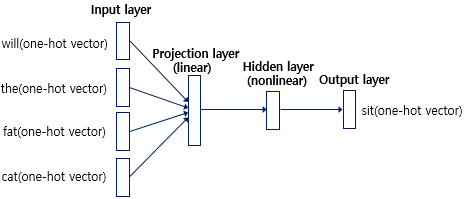

NNLM의 구조를 보겠습니다. NNLM은 위의 그림과 같이 총 4개의 층(layer)으로 이루어진 인공 신경망입니다. 입력층(input layer)을 보면 앞에서 윈도우의 크기는 4로 정하였으므로 입력은 4개의 단어 'will, the, fat, cat'의 원-핫 벡터입니다. 출력층(output layer)을 보면 모델이 예측해야하는 정답에 해당되는 단어 sit의 원-핫 벡터는 모델이 예측한 값의 오차를 구하기 위해 레이블로서 사용됩니다. 그리고 오차로부터 손실 함수를 사용하여 인공 신경망이 학습을 하게 됩니다.

내부 메커니즘을 따라가봅시다. 4개의 원-핫 벡터를 입력 받은 NNLM은 다음층인 투사층(projection layer)을 지나게 됩니다. 인공 신경망에서 입력층과 출력층 사이의 층은 보통 은닉층이라고 부르는데, 여기서 투사층이라고 명명한 이 층은 일반 은닉층과 다르게 가중치 행렬과의 곱셈은 이루어지지만 활성화 함수가 존재하지 않습니다.

투사층의 크기를 M으로 설정하면, 각 입력 단어들은 투사층에서 V × M 크기의 가중치 행렬과 곱해집니다. 여기서 V는 단어 집합의 크기를 의미합니다. 만약 원-핫 벡터의 차원이 7이고, M이 5라면 가중치 행렬 W는 7 × 5 행렬이 됩니다.

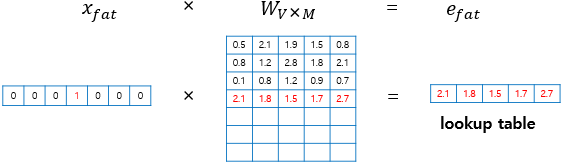

각 단어의 원-핫 벡터와 가중치 W 행렬의 곱이 어떻게 이루어지는지 보겠습니다. 위 그림에서는 각 원-핫 벡터를 $x$로 표기하였습니다. 원-핫 벡터의 특성으로 인해 i번째 인덱스에 1이라는 값을 가지고 그 외의 0의 값을 가지는 원-핫 벡터와 가중치 W 행렬의 곱은 사실 W행렬의 i번째 행을 그대로 읽어오는 것과(lookup) 동일합니다. 그래서 이 작업을 룩업 테이블(lookup table)이라고 합니다.

룩업 테이블 후에는 V차원을 가지는 **원-핫 벡터** 는 이보다 더 차원이 작은 M차원의 벡터로 맵핑됩니다. 위 그림에서 단어 fat을 의미하는 원-핫 벡터를 $x_{fat}$
으로 표현했고, 테이블 룩업 과정을 거친 후의 단어 벡터는 $e_{fat}$으로 표현했습니다. 이 벡터들은 초기에는 랜덤한 값을 가지지만 학습 과정에서 값이 계속 변경되는데 이 단어 벡터를 **임베딩 벡터(embedding vector)** 라고 합니다.

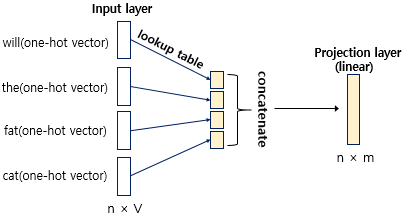

각 단어가 테이블 룩업을 통해 임베딩 벡터로 변경되고, 투사층에서 모든 임베딩 벡터들의 값은 연결됩니다(concatenate). 여기서 벡터의 연결 연산은 벡터들을 이어붙이는 것을 의미합니다. 가령, 5차원 벡터 4개를 연결한다는 의미는 20차원 벡터를 얻는다는 의미입니다. $x$를 각 단어의 원-핫 벡터, NNLM이 예측하고자 하는 단어가 문장에서 $t$번째 단어라고 하고, 윈도우의 크기를 $n$, 룩업 테이블을 의미하는 함수를 $lookup$
, 세미콜론(;)을 연결 기호로 하였을 때 투사층을 식으로 표현하면 아래와 같습니다.

투사층 : $p^{layer} = (lookup(x_{t-n}); ...; lookup(x_{t-2}); lookup(x_{t-1})) = (e_{t-n}; ...; e_{t-2}; e_{t-1})$


일반적인 은닉층이 활성화 함수를 사용하는 비선형층(nonlinear layer)인 것과는 달리 투사층은 활성화 함수가 존재하지 않는 선형층(linear layer)이라는 점이 다소 생소하지만, 이 다음은 다시 은닉층을 사용하는 일반적인 피드 포워드 신경망과 동일합니다.

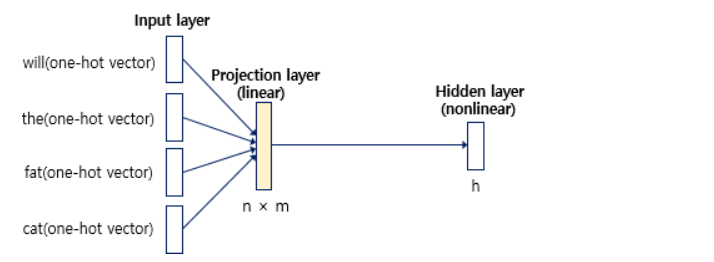

투사층의 결과는 h의 크기를 가지는 은닉층을 지납니다. 일반적인 피드 포워드 신경망에서 은닉층을 지난다는 것은 은닉층의 입력은 가중치 곱해진 후 편향이 더해져 활성화 함수의 입력이 된다는 의미입니다. 이때의 가중치와 편향을 
와 
이라고 하고, 은닉층의 활성화 함수를 하이퍼볼릭탄젠트 함수라고 하였을 때, 은닉층을 식으로 표현하면 아래와 같습니다.

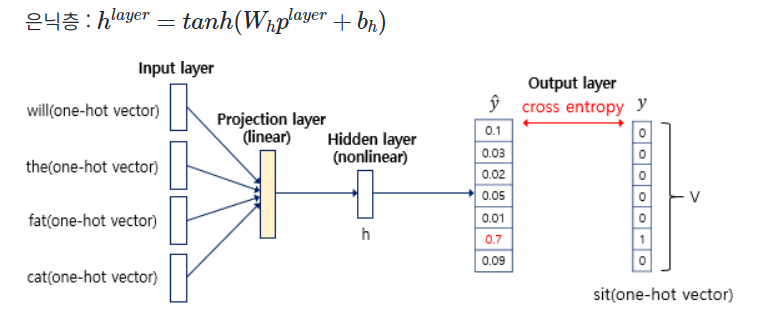

은닉층의 출력은 V의 크기를 가지는 출력층으로 향합니다. 이 과정에서 다시 또 다른 가중치와 곱해지고 편향이 더해지면, 입력이었던 원-핫 벡터들과 동일하게 V차원의 벡터를 얻습니다. 만약 입력 벡터의 차원이 7이었다면 해당 벡터도 동일한 차원 수를 가집니다. 출력층에서는 활성화 함수로 소프트맥스(softmax) 함수를 사용하는데, V차원의 벡터는 소프트맥스 함수를 지나면서 벡터의 각 원소는 0과 1사이의 실수값을 가지며 총 합은 1이 되는 상태로 바뀝니다. 이 벡터를 NNLM의 예측값이라는 의미에서 $\hat{y}$라고 합시다. 이를 식으로 표현하면 아래와 같습니다.

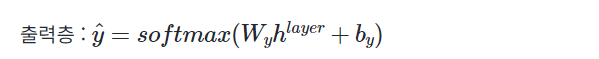

벡터 $\hat{y}$의 각 차원 안에서의 값이 의미하는 것은 이와 같습니다. 
의 j번째 인덱스가 가진 0과 1사이의 값은 j번째 단어가 다음 단어일 확률을 나타냅니다. 그리고 $\hat{y}$는 실제값. 즉, 실제 정답에 해당되는 단어인 원-핫 벡터의 값에 가까워져야 합니다. 실제값에 해당되는 다음 단어를 $\hat{y}$라고 했을 때, 이 두 벡터가 가까워지게 하기위해서 NNLM는 손실 함수로 크로스 엔트로피(cross-entropy) 함수를 사용합니다. 해당 문제는 단어 집합의 모든 단어라는 V개의 선택지 중 정답인 'sit'을 예측해야하는 다중 클래스 분류 문제입니다. 그리고 역전파가 이루어지면 모든 가중치 행렬들이 학습되는데, 여기에는 투사층에서의 가중치 행렬도 포함되므로 임베딩 벡터값 또한 학습됩니다.

이번 예제에서는 7개의 단어만 사용했지만, 만약 충분한 훈련 데이터가 있다는 가정 하에 NNLM이 얻을 수 있는 이점은 무엇일까요? NNLM의 핵심은 충분한 양의 훈련 코퍼스를 위와 같은 과정으로 학습한다면 결과적으로 수많은 문장에서 유사한 목적으로 사용되는 단어들은 결국 유사한 임베딩 벡터값을 얻게되는 것에 있습니다. 이렇게 되면 훈련이 끝난 후 다음 단어를 예측 과정에서 (마치 앞서 언급한 저자의 '톺아보기'와 같은 예시처럼) 훈련 코퍼스에서 없던 단어 시퀀스라 하더라도 다음 단어를 선택할 수 있습니다.

단어 간 유사도를 구할 수 있는 임베딩 벡터의 아이디어는 Word2Vec, FastText, GloVe 등으로 발전되어서 딥 러닝 자연어 처리 모델에서는 필수적으로 사용되는 방법이 되었습니다. 임베딩 벡터에 대해서는 워드 임베딩 챕터에서 좀 더 자세히 다룹니다.

---
### **4. NNLM의 이점과 한계**
NNLM은 기존 n-gram 언어 모델의 한계를 개선하였지만 여전히 가지는 문제점이 있습니다.

#### **1) 기존 모델에서의 개선점**
NNLM은 단어를 표현하기 위해 임베딩 벡터를 사용하므로서 단어의 유사도를 계산할 수 있었습니다. 그리고 이를 통해 희소 문제(sparsity problem)를 해결하였습니다.

#### **2) 고정된 길이의 입력(Fixed-length input)**
NNLM이 극복하지 못한 한계 또한 존재합니다. NNLM은 n-gram 언어 모델과 마찬가지로 다음 단어를 예측하기 위해 모든 이전 단어를 참고하는 것이 아니라 정해진 n개의 단어만을 참고할 수 있습니다. 이 한계를 극복할 수 있는 언어 모델이 있는데, 다음 챕터에서 배우게 될 RNN(Recurrent Neural Network)을 사용한 RNN 언어 모델(Recurrent Neural Network Language Model, RNNLM)입니다.

마지막 편집일시 : 2022년 11월 14일 2:50 오후